# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [3]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from typing import NoReturn

In [4]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [60]:
class Perceptron:
    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """

        self.w = None
        self.iterations = iterations
        self.scaler = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает простой перцептрон. 
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        n, dim = X.shape
        mn, mx = y.min(), y.max()
        y = (y - mn) / (mx - mn) * 2 - 1
        self.scaler = mn, mx
        np.random.seed(0)
        w = np.random.normal(size=(dim + 1, 1))
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        for _ in range(self.iterations):
            for i in range(n):
                if np.sign(w.T @ X[i]) != y[i]:
                    w = w + y[i] * X[i].reshape((-1, 1))
                    break
        self.w = w
        
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        n, dim = X.shape
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        labels = np.sign(X @ self.w).reshape(-1).astype('int8')
        mn, mx = self.scaler
        labels = (labels + 1) * (mx - mn) / 2 + mn
        return labels

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

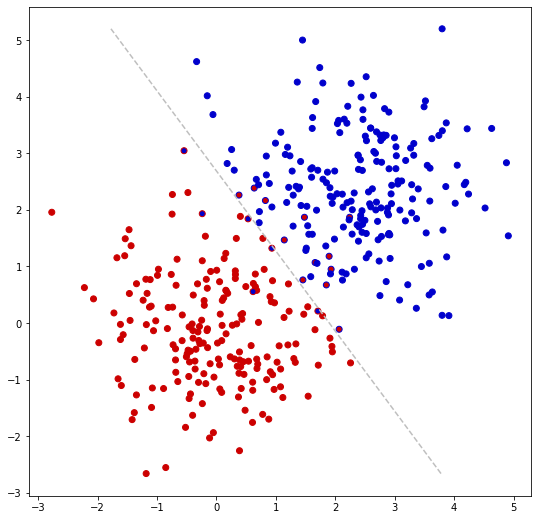

CPU times: user 534 ms, sys: 8.07 ms, total: 542 ms
Wall time: 647 ms


In [61]:
%%time
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

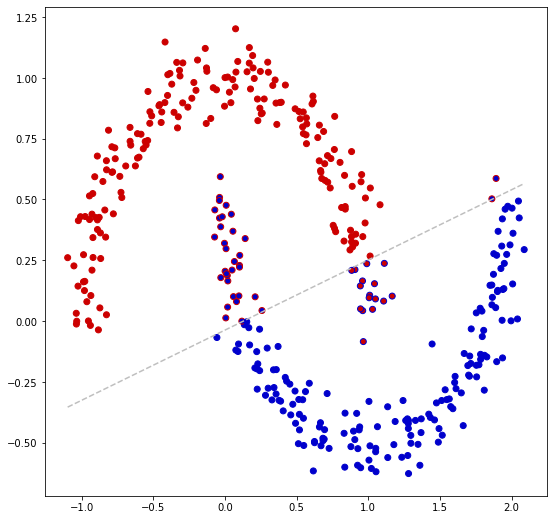

In [62]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [63]:
class PerceptronBest:

    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """

        self.w = None
        self.iterations = iterations
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона, 
        а затем обновляет их в течении iterations итераций.

        При этом в конце обучения оставляет веса, 
        при которых значение accuracy было наибольшим.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        n, dim = X.shape
        mn, mx = y.min(), y.max()
        y = (y - mn) / (mx - mn) * 2 - 1
        self.scaler = mn, mx
        np.random.seed(0)
        w = np.random.normal(size=(dim + 1, 1))
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        max_accuracy = 0
        w_best = w
        for _ in range(self.iterations):
            for i in range(n):
                if np.sign(w.T @ X[i]) != y[i]:
                    w = w + y[i] * X[i].reshape((-1, 1))
                    break
            acc = np.sum(np.sign(X @ w).reshape(-1) == y) / n
            if acc > max_accuracy:
                w_best = w
                max_accuracy = acc
        self.w = w_best
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        n, dim = X.shape
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        labels = np.sign(X @ self.w).reshape(-1).astype('int8')
        mn, mx = self.scaler
        labels = (labels + 1) * (mx - mn) / 2 + mn
        return labels

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

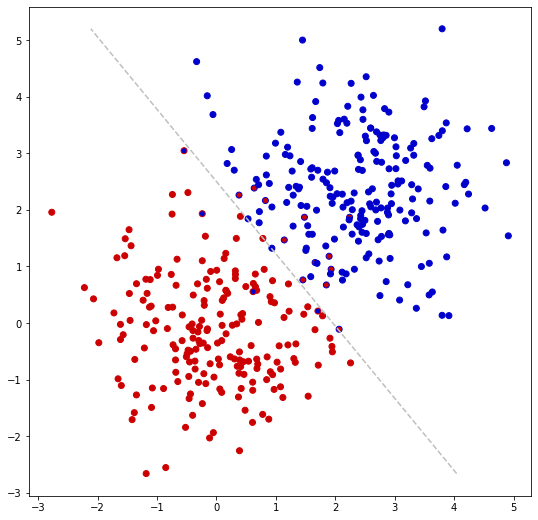

In [64]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

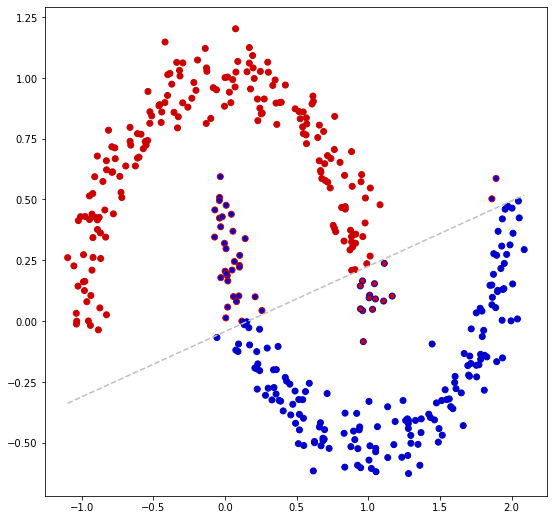

In [65]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [66]:
def transform_images(images: np.ndarray) -> np.ndarray:
    """
    Переводит каждое изображение в вектор из двух элементов.
        
    Parameters
    ----------
    images : np.ndarray
        Трехмерная матрица с черное-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).

    Return
    ------
    np.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    n_images, image_height, image_width = images.shape
    transformed = np.zeros((n_images, 2))
    eps=1e-2
    for i in range(n_images):
        x = images[i]
        symmetry = np.sum(abs(x - np.flip(x, axis=0)))
        intensity = len(x[x > eps])
        transformed[i] = np.array([symmetry, intensity])
    return transformed

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [67]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [68]:
print(y_test[:20])
X_test[:20]

[5 5 5 5 1 5 1 1 1 5 5 1 1 1 1 1 5 1 5 5]


array([[19.75 , 35.   ],
       [14.625, 37.   ],
       [16.75 , 38.   ],
       [16.5  , 36.   ],
       [12.   , 33.   ],
       [17.25 , 35.   ],
       [ 9.5  , 31.   ],
       [13.5  , 30.   ],
       [11.625, 32.   ],
       [14.   , 32.   ],
       [12.25 , 30.   ],
       [11.75 , 33.   ],
       [ 8.375, 28.   ],
       [11.75 , 29.   ],
       [ 8.625, 29.   ],
       [ 9.25 , 30.   ],
       [16.875, 33.   ],
       [11.875, 31.   ],
       [18.5  , 30.   ],
       [12.5  , 36.   ]])

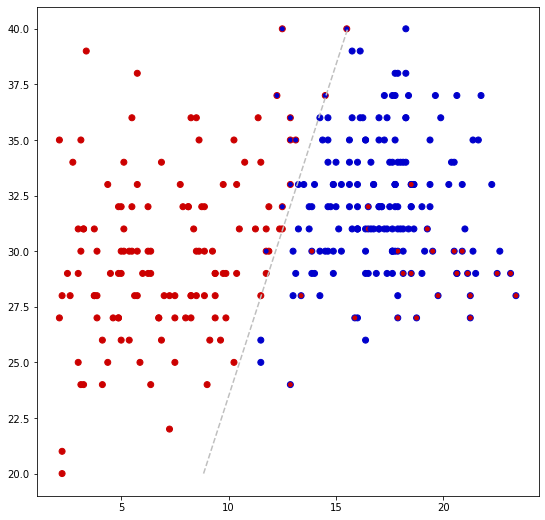

Accuracy: 0.958904109589041


In [70]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

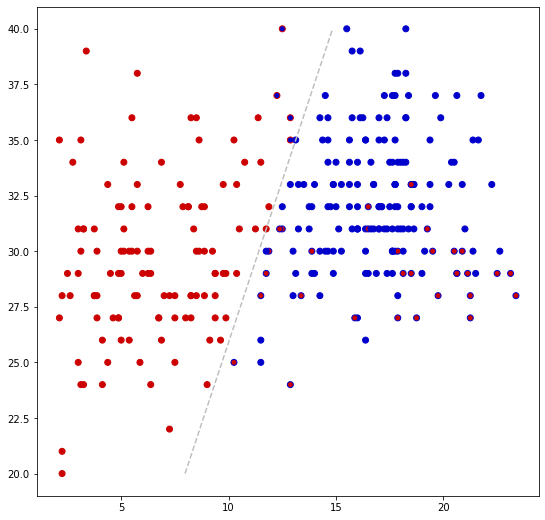

Accuracy: 0.9315068493150684


In [71]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [72]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6744141578712933


In [73]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.7372981589860489
